In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tox21_project import deeplearning as dl
from tox21_project import testing as tt
from tox21_project import data_preprocessing as dp

## 1. 导入所有计算的文件，并做一个简单的观察

In [2]:
type_names = ['descriptors', 'fingerprint', 'similarity']
layers = [[1024],[1024,2048],[1024,2048,4196]]

# 模型名称
model_names = []
for t in type_names:
    for layer in layers:
        model_names.append(t + '_' + '_'.join([str(l) for l in layer]) + '_pca')
        model_names.append(t + '_' + '_'.join([str(l) for l in layer]))

In [3]:
# 模型计算结果，去除 val auprc 是null值的文件
model_drop_null = []
for m in model_names:
    if pd.read_csv('data/dnn_data/' + m + '.csv').isnull().sum()['val auprc'] != 0:
        continue
    else:
        model_drop_null.append(m)

In [4]:
len(model_drop_null)

18

画出模型计算val loss 和 val auprc 的曲线图

Text(0, 0.5, 'Valid Loss')

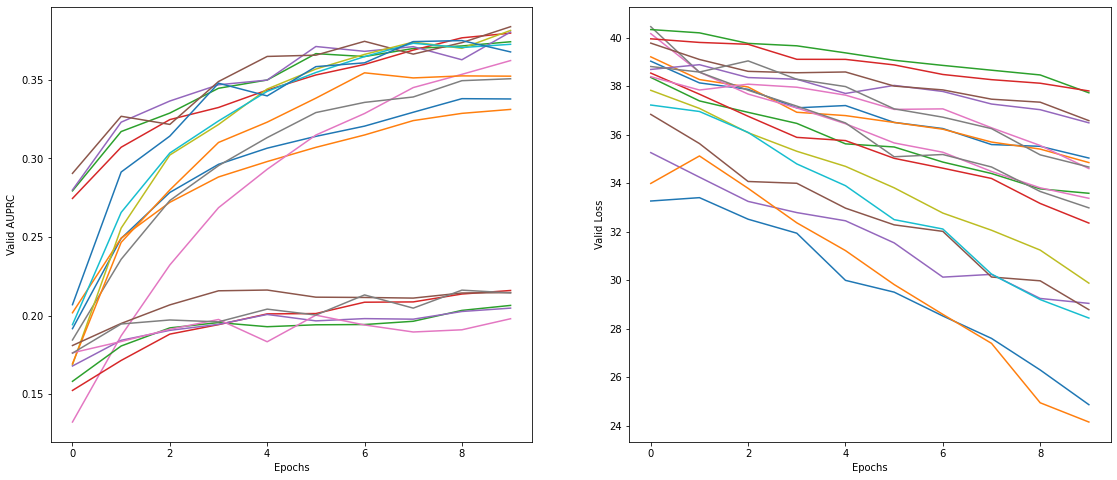

In [5]:
auprc = []
loss = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 8))

for m in model_drop_null:
    # 1. 读取数据
    filename = 'data/dnn_data/' + m + '.csv'
    df = pd.read_csv(filename, index_col=0)
    # 2. 取末尾5个epoch的平均值，作为后面的选取条件
    t = df.tail(5)[['val loss', 'val auprc']].mean().to_dict()
    auprc.append(t['val auprc'])
    loss.append(t['val loss'])
    # 3. 画图
    ax1.plot(df['val auprc'].values)
    ax2.plot(df['val loss'].values)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Valid AUPRC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Valid Loss')

## 2. 根据AUPRC选择合适的模型

In [6]:
# argsort 返回的是元素值从小到大排序后的索引值的数组
# [m::n]下标为m开始，间隔为n，来取元素
AUPRC = np.argsort(np.array(auprc))[::-1]
LOSS = np.argsort(np.array(loss))

In [7]:
np.array(auprc)[AUPRC]

array([0.37269209, 0.37061739, 0.3695932 , 0.36932727, 0.36752954,
       0.36714008, 0.36705782, 0.34966823, 0.34075874, 0.34071654,
       0.32786945, 0.32108743, 0.21265757, 0.2097568 , 0.20962246,
       0.19994788, 0.19891336, 0.19455751])

In [8]:
final_model = model_drop_null[AUPRC[0]]
final_model

'descriptors_1024_2048_4196'

In [9]:
checkpoint = torch.load('models/dnn_models/' + final_model + '.pth')
final_model = checkpoint['model']

## 3. 再训练

数据

In [10]:
targets = ['SR-HSE','NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',\
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']

# 读取数据，根据最后的模型来选取
raw_X = pd.read_csv('data/molecular_descriptors.csv', index_col=0).iloc[:, 2:]
raw_y = pd.read_csv('data/data_dups_removed.csv', index_col=0)[targets]

# 处理null
null_mask = np.array(np.logical_not(raw_y.isnull().values), int)
raw_y = raw_y.fillna(0.0)
mask_df = pd.DataFrame(null_mask, columns=[str(i) + '_mask' for i in targets], index=raw_y.index)
raw_y = pd.concat([raw_y, mask_df], axis=1)

# 分割
train_X, test_X, train_y, test_y = train_test_split(raw_X, raw_y, test_size=0.2, random_state=42)

# y和mask
train_y, train_mask = train_y[targets], train_y[mask_df.columns]
test_y, test_mask = test_y[targets], test_y[mask_df.columns]

In [11]:
def transform(train, test, apply):
    train_new = apply.fit_transform(train)
    test_new = apply.transform(test)
    return train_new, test_new
train_X, test_X = transform(train_X, test_X, StandardScaler())

In [12]:
def prepare_data(with_pca, train_X, train_y, train_mask, test_X, test_y, test_mask, batch_size):
    """PCA降维一半"""
    if with_pca:
        pca_shape = train_X.shape[1] // 2
        pca = PCA(pca_shape)
        train_X = pca.fit_transform(train_X)
        test_X = pca.transform(test_X)
    return dl.get_data(train_X, train_y, train_mask, test_X, test_y, test_mask, batch_size)

参数

In [13]:
epochs = 20
output_size = 12
optimizer = checkpoint['optimizer']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 128

训练

In [14]:
def run(epochs, with_pca):
    # 数据获取
    train_set, valid_set, train_loader = prepare_data(with_pca, train_X, train_y, train_mask, test_X, test_y, test_mask, batch_size)
    input_size = len(train_set[0][0])
    
    # 参数设置
    criterion = nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False)
    early_stop = dl.EarlyStopping()
    trainer = dl.Trainer(final_model, optimizer, criterion, epochs, device, scheduler, early_stop)
    
    # 训练
    res = trainer.train_model(train_loader, valid_set, 'final_model')
    return res, valid_set

In [15]:
res, test_set = run(epochs, False)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20]----train loss: 23.179459  val loss: 27.955612  AUPRC: 0.385  AUCROC: 0.816
Epoch [11/20]----train loss: 14.145755  val loss: 17.241781  AUPRC: 0.421  AUCROC: 0.827


## 4. 测试和总结

In [16]:
X_test, y_test, mask_test = test_set[:]

test_panel = tt.panel_of_test(targets, y_test, mask_test)

y_scores = final_model(X_test.to(device).float()).cpu().detach().numpy() # 概率预测
y_pred = np.array(y_scores > 0.5, int) # 分类预测

metrics = test_panel.compute_basic_metrics(y_pred, y_scores)
metrics

  0%|          | 0/12 [00:00<?, ?it/s]

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.428571,0.130435,0.2,0.277232,0.94533,0.56041,0.804394
NR-AR,0.848485,0.491228,0.622222,0.556323,0.977212,0.743872,0.801699
SR-ARE,0.708861,0.28,0.401434,0.580551,0.860949,0.628511,0.837283
NR-Aromatase,0.466667,0.205882,0.285714,0.361221,0.941812,0.595893,0.814356
NR-ER-LBD,0.606061,0.31746,0.416667,0.446707,0.960839,0.653975,0.848713
NR-AhR,0.791045,0.33125,0.46696,0.632663,0.910964,0.659787,0.902179
SR-MMP,0.8,0.537634,0.643087,0.758611,0.905932,0.756242,0.92266
NR-ER,0.676923,0.291391,0.407407,0.488841,0.898493,0.636236,0.764441
NR-PPAR-gamma,0.285714,0.052632,0.088889,0.157754,0.968678,0.524349,0.822291
SR-p53,0.617647,0.223404,0.328125,0.391913,0.937726,0.606652,0.841045


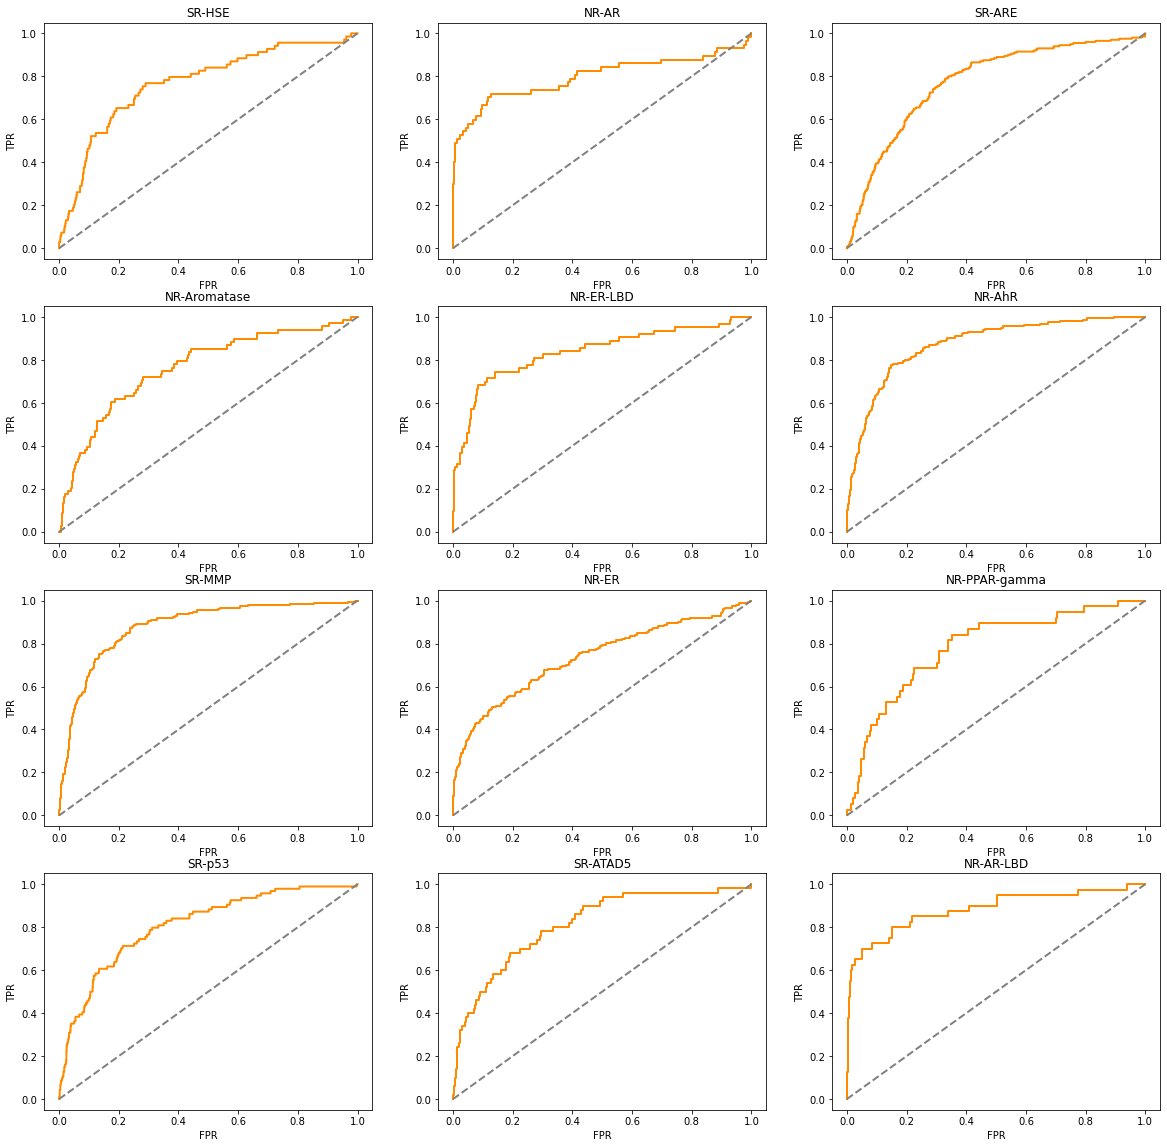

In [18]:
test_panel.plot_roc(y_scores)